In [1]:
#Imports & Setup
import os
import time
from sched import scheduler

import torch
import torch.nn as nn
import torch.optim as optim
from sympy import CosineTransform
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
DATA_PATH = r"data/flowers"
BATCH_SIZE = 32
IMG_SIZE = 224

# Аугментація advanced
# Random augmentations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # num_ops=2: застосувати 2 випадкові операції поспіль
    # magnitude=9: сила змін
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# MixUp - змішуємо два зображення разом

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# CutMix - вирізаємо частину з одного зображення і вставляємо в інше

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size, _, h, w = x.size()
    index = torch.randperm(batch_size).to(device)

    # Генерує координати квадрата
    cx = np.random.randint(w)
    cy = np.random.randint(h)
    cut_w = int(w * np.sqrt(1 - lam))
    cut_h = int(h * np.sqrt(1 - lam))

    x1 = np.clip(cx - cut_w // 2, 0, w)
    y1 = np.clip(cy - cut_h // 2, 0, h)
    x2 = np.clip(cx + cut_w // 2, 0, w)
    y2 = np.clip(cy + cut_h // 2, 0, h)

    #Клонує x, щоб не псувати оригінал
    mixed_x = x.clone()
    mixed_x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]

    # Перераховує лямбду під реальну площу латки
    lam = 1 - ((x2 - x1) * (y2 - y1) / (w * h))
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Функція втрат
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Для валідації - тільки стандартна обробка
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Завантаження та спліт
try:
    full_dataset = datasets.ImageFolder(DATA_PATH)
    num_classes = len(full_dataset.classes)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

    # Ми створюємо окремі класи Dataset, щоб не конфліктували трансформації
    class TransformedSubset(torch.utils.data.Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                x = self.transform(x)
            return x, y
        def __len__(self):
            return len(self.subset)

    train_ds = TransformedSubset(train_subset, transform=train_transform)
    val_ds = TransformedSubset(val_subset, transform=val_transform)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

    print(f"Data loaded. Classes: {full_dataset.classes}")
    print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)}")

except Exception as e:
    print(f"Error: {e}")

Data loaded. Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Train size: 3453 | Val size: 864


In [3]:
# Імпорти
import torch.nn as nn
import torch.optim as optim
from torchvision import models

from models.transfer_models import get_resnet18, get_densenet121

print("Models successfully imported from file!")


Models successfully imported from file!


In [4]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / labels.size(0)

def plot_training_history(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Training DenseNet121_FineTuning...
Ep 1/30 | Train Acc: 0.6884 | Train Loss: 0.9929 | Val Acc: 0.9190 | Val Loss: 0.5930
Ep 2/30 | Train Acc: 0.7550 | Train Loss: 0.8163 | Val Acc: 0.9491 | Val Loss: 0.5537
Ep 3/30 | Train Acc: 0.8005 | Train Loss: 0.7563 | Val Acc: 0.9375 | Val Loss: 0.5646
Ep 4/30 | Train Acc: 0.8509 | Train Loss: 0.7070 | Val Acc: 0.9444 | Val Loss: 0.5288
Ep 5/30 | Train Acc: 0.8170 | Train Loss: 0.7111 | Val Acc: 0.9491 | Val Loss: 0.5276
Ep 6/30 | Train Acc: 0.8167 | Train Loss: 0.7433 | Val Acc: 0.9468 | Val Loss: 0.5247
Ep 7/30 | Train Acc: 0.8219 | Train Loss: 0.6952 | Val Acc: 0.9491 | Val Loss: 0.5419
Ep 8/30 | Train Acc: 0.8422 | Train Loss: 0.6765 | Val Acc: 0.9537 | Val Loss: 0.5189
Ep 9/30 | Train Acc: 0.8315 | Train Loss: 0.7077 | Val Acc: 0.9537 | Val Loss: 0.5176
Ep 10/30 | Train Acc: 0.8520 | Train Loss: 0.6522 | Val Acc: 0.9525 | Val Loss: 0.5178
Ep 11/30 | Train Acc: 0.8149 | Train Loss: 0.6853 | Val Acc: 0.9537 | Val Loss: 0.5157
Ep 12/30 | Train 

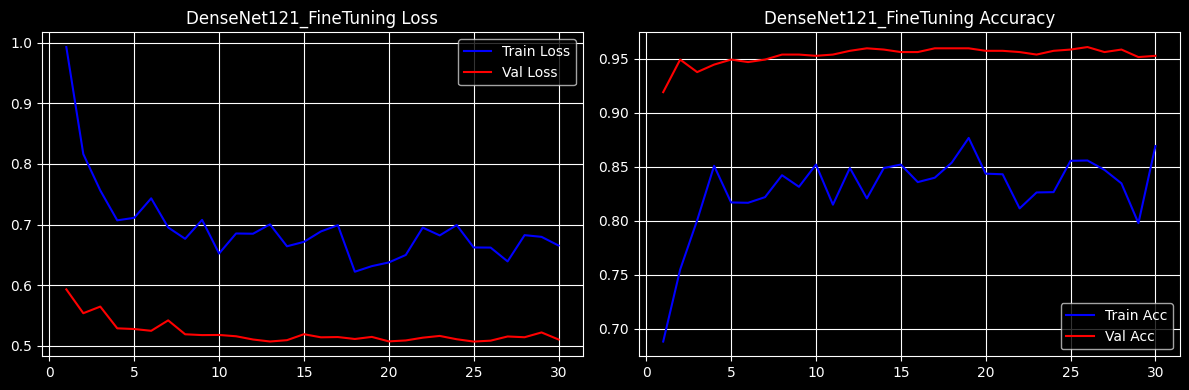

Best Accuracy: 0.9606


In [5]:
MODEL_NAME = "DenseNet121_FineTuning"
EPOCHS = 30 # Більше епох, бо аугментація + регуляризація ускладнює навчання

print(f"Training {MODEL_NAME}...")

# Dropout додано в модель у файлі models/transfer_models.py
DROPOUT_PROB = 0.1
model = get_densenet121(feature_extract=False, num_classes=num_classes, dropout=DROPOUT_PROB).to(device)

# LABEL SMOOTHING
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Оптимізатор з weight_decay для регуляризації
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # weight_decay для 3.1

# 3. SCHEDULER
# mode='max' -> бо ми будемо дивитися на Accuracy (вона має рости)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


# 3. Цикл навчання
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_acc, n_train = 0, 0, 0
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        r = np.random.rand()

        # Apply MixUp or CutMix
        if r < 0.25:
            imgs, targets_a, targets_b, lam = mixup_data(imgs, labels)
            outputs = model(imgs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        elif r < 0.5:
            imgs, targets_a, targets_b, lam = cutmix_data(imgs, labels)
            outputs = model(imgs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        # На тренуванні точність рахуємо приблизно (по argmax), бо мітки змішані
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == labels).sum().item()
        n_train += imgs.size(0)

    model.eval()
    val_loss, val_acc, n_val = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_acc += calculate_accuracy(outputs, labels) * imgs.size(0)
            n_val += imgs.size(0)


    # Stats
    epoch_acc = val_acc / n_val
    epoch_loss = val_loss / n_val

    # Крок Scheduler (передаємо epoch_acc)
    scheduler.step(epoch_acc)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss / n_train)
    history['val_loss'].append(val_loss / n_val)
    history['train_acc'].append(train_acc / n_train)
    history['val_acc'].append(val_acc / n_val)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        os.makedirs("checkpoints", exist_ok=True)
        torch.save(model.state_dict(), "checkpoints/densenet121_ft_advaug_reg_best.pth")

    print(f"Ep {epoch+1}/{EPOCHS} | Train Acc: {train_acc/n_train:.4f} | Train Loss: {train_loss/ n_train:.4f} | Val Acc: {epoch_acc:.4f} | Val Loss: {val_loss/n_val:.4f}")

plot_training_history(history, MODEL_NAME)
print(f"Best Accuracy: {best_acc:.4f}")

In [6]:
# Клітинка для збереження графіка

os.makedirs("results", exist_ok=True)

def save_plot(history, filename):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend(); plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend(); plt.grid(True)

    # ЗБЕРЕЖЕННЯ
    save_path = os.path.join("results", filename)
    plt.savefig(save_path)
    print(f"Графік збережено: {save_path}")
    plt.close()

# Зберігаємо з конкретним ім'ям
save_plot(history, "DenseNet121_FT_AdvAug_Reg.png")

Графік збережено: results\DenseNet121_FT_AdvAug_Reg.png
